In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc

import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import utils as np_utils

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D,\
UpSampling1D, InputLayer

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
import joblib
from sklearn.neighbors import LocalOutlierFactor
from sklearn import cluster, datasets

import random
import os
import cv2
import matplotlib.image as mpimg
%matplotlib inline

In [5]:
root_path = "/Users/I559573/Library/CloudStorage/OneDrive-SAPSE/Documents/D2V2.0_PREP/btp-ai-core-bootcamp/\
src/ai-models/defect-detection/data"
path_img_ok = root_path + "/Images/OK/"
path_img_ko = root_path + "/Images/NG/"
path_msk_ok = root_path + "/Masks/OK_MSK/"
path_msk_ko = root_path + "/Masks/NG_MSK/"
print(path_img_ok)
print(path_img_ko)
print(path_msk_ok)
print(path_msk_ko)

/Users/I559573/Library/CloudStorage/OneDrive-SAPSE/Documents/D2V2.0_PREP/btp-ai-core-bootcamp/src/ai-models/defect-detection/data/Images/OK/
/Users/I559573/Library/CloudStorage/OneDrive-SAPSE/Documents/D2V2.0_PREP/btp-ai-core-bootcamp/src/ai-models/defect-detection/data/Images/NG/
/Users/I559573/Library/CloudStorage/OneDrive-SAPSE/Documents/D2V2.0_PREP/btp-ai-core-bootcamp/src/ai-models/defect-detection/data/Masks/OK_MSK/
/Users/I559573/Library/CloudStorage/OneDrive-SAPSE/Documents/D2V2.0_PREP/btp-ai-core-bootcamp/src/ai-models/defect-detection/data/Masks/NG_MSK/


Data inspection

In [6]:
def print_random_images(img_folder):
    for i in range(5):
        lst = os.listdir(img_folder)
        lst.sort()
        file = lst[i]
        image_path = os.path.join(img_folder, file)
        img = mpimg.imread(image_path)
        ax = plt.subplot(1, 5, i+1)
        ax.title.set_text(file)
        plt.imshow(img)

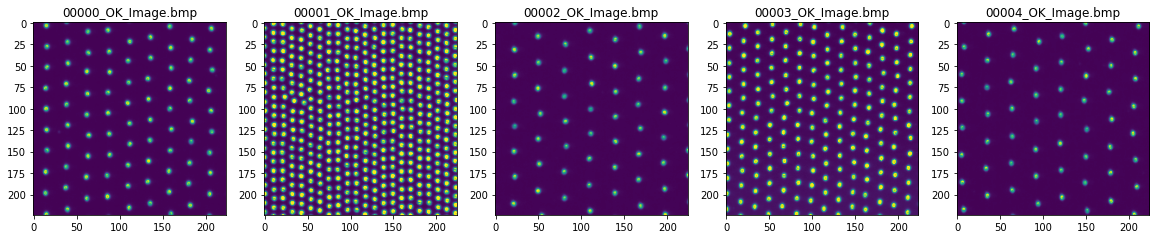

In [7]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ok)

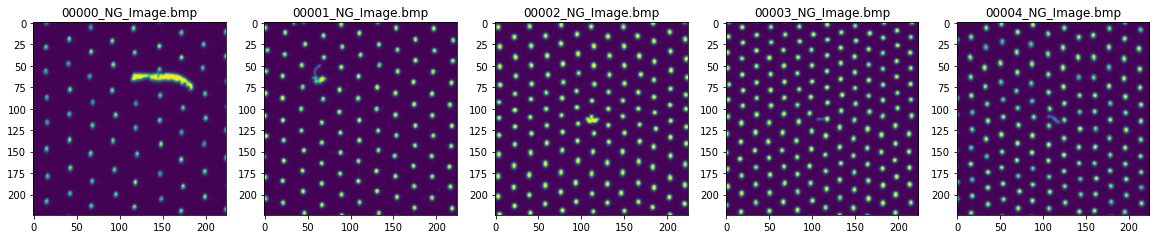

In [8]:
plt.figure(figsize = (20, 20))
print_random_images(path_img_ko)

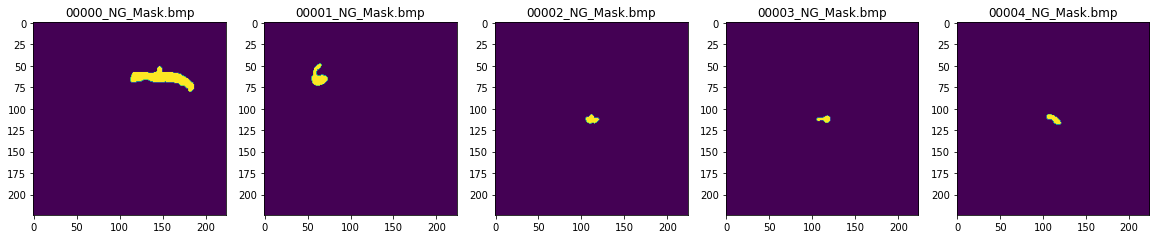

In [9]:
plt.figure(figsize = (20, 20))
print_random_images(path_msk_ko)

Dataframe creation

In [10]:
IMG_WIDTH=224
IMG_HEIGHT=224
MSK_WIDTH=184
MSK_HEIGHT=184

def create_dataset(img_folder, bnw, binary, width, height):
    img_data_array = []
    color_str = cv2.COLOR_BGR2GRAY
    color_int = 1
    if(bnw):
        color_str = cv2.cv2.IMREAD_GRAYSCALE
        color_int = 1
    for file in sorted(os.listdir(img_folder)):
            image_path = os.path.join(img_folder, file)
            image = cv2.imread(image_path, color_str)
            if(not(bnw)):
                clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
                image = clahe.apply(image)
                kernel = np.ones((3,3),np.uint8)
                image = cv2.dilate(image,kernel,iterations = 1)
            image = cv2.resize(image, (height, width), interpolation = cv2.INTER_AREA)
            image = np.array(image)
            image = image.astype('float32')
            image /= 255
            image = np.reshape(image, (width, height, color_int))
            if(bnw):
                image = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)[1]
            if(binary):
                image = image.tobytes()
            img_data_array.append(image)
    return img_data_array

In [11]:
# extract the image array and class name
img_dataset_ok = create_dataset(path_img_ok, False, False, IMG_WIDTH, IMG_HEIGHT)
img_dataset_ko = create_dataset(path_img_ko, False, False, IMG_WIDTH, IMG_HEIGHT)
msk_dataset_ok = create_dataset(path_msk_ok, True, False, MSK_WIDTH, MSK_HEIGHT)
msk_dataset_ko = create_dataset(path_msk_ko, True, False, MSK_WIDTH, MSK_HEIGHT)

img_dataset_ok_bin = create_dataset(path_img_ok, False, True, IMG_WIDTH, IMG_HEIGHT)
img_dataset_ko_bin = create_dataset(path_img_ko, False, True, IMG_WIDTH, IMG_HEIGHT)
msk_dataset_ok_bin = create_dataset(path_msk_ok, True, True, MSK_WIDTH, MSK_HEIGHT)
msk_dataset_ko_bin = create_dataset(path_msk_ko, True, True, MSK_WIDTH, MSK_HEIGHT)

Check correctness of the array content

(224, 224, 1)
(184, 184)


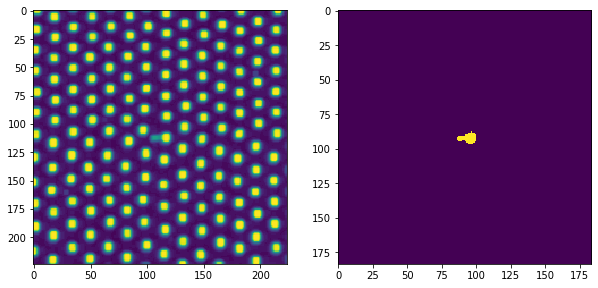

In [12]:
i = 3
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(img_dataset_ko[i], interpolation='nearest')
axs[1].imshow(msk_dataset_ko[i], interpolation='nearest')
print(img_dataset_ko[i].shape)
print(msk_dataset_ko[i].shape)

Dataframe creation with images stored as binary

In [13]:
df_img_dataset_ok = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ok['image'] = img_dataset_ok_bin
df_img_dataset_ok['label'] = 0
#df_img_dataset_ok

In [14]:
df_img_dataset_ko = pd.DataFrame(columns = ['image','label'])
df_img_dataset_ko['image'] = img_dataset_ko_bin
df_img_dataset_ko['label'] = 1
#df_img_dataset_ko

In [15]:
df_msk_dataset_ok = pd.DataFrame(columns = ['mask'])
df_msk_dataset_ok['mask'] = msk_dataset_ok_bin
#df_msk_dataset_ok

In [16]:
df_msk_dataset_ko = pd.DataFrame(columns = ['mask'])
df_msk_dataset_ko['mask'] = msk_dataset_ko_bin
#df_msk_dataset_ok

In [17]:
df_img_dataset_tot = pd.concat([df_img_dataset_ok,df_img_dataset_ko], ignore_index=True)
df_msk_dataset_tot = pd.concat([df_msk_dataset_ok,df_msk_dataset_ko], ignore_index=True)

In [18]:
df_dataset_tot = pd.merge(df_img_dataset_tot, df_msk_dataset_tot, left_index=True, right_index=True)

Check dataframe content by decoding the images:

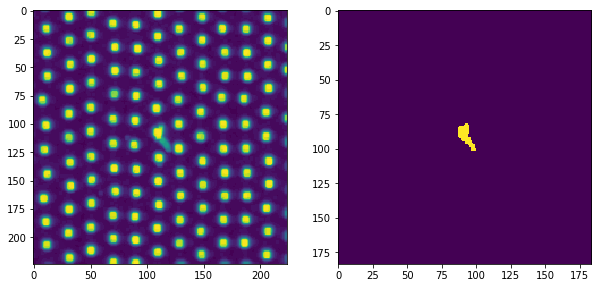

In [19]:
i = 23
fig, axs = plt.subplots(1, 2, figsize=(10,10))
img = np.frombuffer(df_dataset_tot[df_dataset_tot.label==1]['image'].iloc[i], dtype=np.float32)
img = np.reshape(img, (IMG_WIDTH,IMG_HEIGHT,1))
axs[0].imshow(img, interpolation='nearest')
img = np.frombuffer(df_dataset_tot[df_dataset_tot.label==1]['mask'].iloc[i], dtype=np.float32)
img = np.reshape(img, (MSK_WIDTH,MSK_HEIGHT,1))
axs[1].imshow(img, interpolation='nearest')

Reshuffle and split the dataframe

In [61]:
df_dataset_tot = df_dataset_tot.sample(frac=1).reset_index(drop=True)

In [62]:
df_dataset_train, df_dataset_test = train_test_split(df_dataset_tot, test_size=0.99, random_state=25)

In [63]:
df_dataset_val, df_dataset_test = train_test_split(df_dataset_test, test_size=0.99, random_state=25)

In [64]:
df_dataset_train.groupby("label")['image'].count()

label
0    4
1    4
Name: image, dtype: int64

In [65]:
df_dataset_test.groupby("label")['image'].count()

label
0    393
1    413
Name: image, dtype: int64

In [66]:
df_dataset_val.groupby("label")['image'].count()

label
0    3
1    5
Name: image, dtype: int64

In [67]:
print(f"No. of training examples: {df_dataset_train.shape[0]}")
print(f"No. of testing examples: {df_dataset_test.shape[0]}")
print(f"No. of validation examples: {df_dataset_val.shape[0]}")

No. of training examples: 8
No. of testing examples: 806
No. of validation examples: 8


Convert back images and create corresponding arrays of images

In [68]:
def convert_back(df, type, color_int, width, height):
    temp_arr = []
    for i in df[type].values:
        a = np.frombuffer(i, dtype=np.float32)
        a = a.reshape(width,height,color_int)
        temp_arr.append(a)
        #print(a.shape)
    return temp_arr

img_train = convert_back(df_dataset_train, 'image', 1, IMG_WIDTH, IMG_HEIGHT)
img_test = convert_back(df_dataset_test, 'image', 1, IMG_WIDTH, IMG_HEIGHT)
img_val = convert_back(df_dataset_val, 'image', 1, IMG_WIDTH, IMG_HEIGHT)

msk_train = convert_back(df_dataset_train, 'mask', 1, MSK_WIDTH, MSK_HEIGHT)
msk_test = convert_back(df_dataset_test, 'mask', 1, MSK_WIDTH, MSK_HEIGHT)
msk_val = convert_back(df_dataset_val, 'mask', 1, MSK_WIDTH, MSK_HEIGHT)

print(len(img_train), len(msk_train))
print(len(img_test), len(msk_test))
print(len(img_val), len(msk_val))

print(img_train[0].shape, msk_train[0].shape)
print(img_test[0].shape, msk_test[0].shape)
print(img_val[0].shape, msk_val[0].shape)

8 8
806 806
8 8
(224, 224, 1) (184, 184, 1)
(224, 224, 1) (184, 184, 1)
(224, 224, 1) (184, 184, 1)


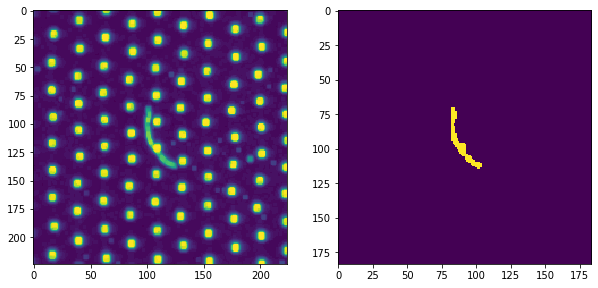

In [30]:
i = 0
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(img_test[i], interpolation='nearest')
axs[1].imshow(msk_test[i], interpolation='nearest')
#print(img_test[i].shape)
#print(msk_test[i].shape)

Data augmentation:

In [31]:
import albumentations as A
def image_transform(img, msk):
    transform = A.Compose([
        #A.RandomRotate90(),
        A.Flip(),
        #A.Transpose(),
        #A.OneOf([
        #    A.MotionBlur(p=.2),
        #    A.MedianBlur(blur_limit=3, p=0.3),
        #    A.Blur(blur_limit=3, p=0.1),
        #], p=0.2),
        #A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        #A.OneOf([
        #    A.OpticalDistortion(p=0.3),
        #    A.GridDistortion(p=.1),
        #], p=0.2),
        A.OneOf([
            #A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        #A.HueSaturationValue(p=0.3),
    ])
    transformed = transform(image=img, mask=msk)
    return transformed['image'], transformed['mask']

In [32]:
def data_aug(img_list, msk_list):
    img_newlist = []
    msk_newlist = []
    for i in range(len(img_list)):
        #print(i)
        img, msk = image_transform(img_list[i], msk_list[i])
        img_newlist.append(img)
        msk_newlist.append(msk)
    return img_newlist, msk_newlist

In [33]:
a, b = data_aug(img_train, msk_train)

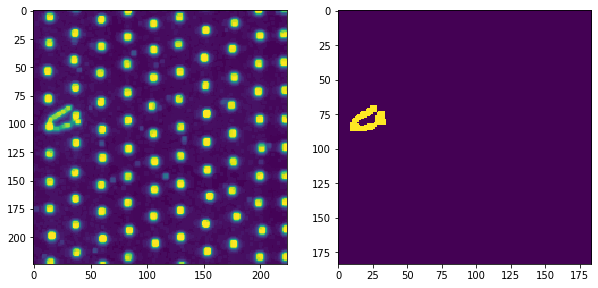

In [36]:
#test_img, test_msk = data_aug(img_test[25], msk_test[25])
i=7
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(a[i], interpolation='nearest')
axs[1].imshow(b[i], interpolation='nearest')

Build the model (reproducing a U-Net architecture)

In [37]:
from tensorflow.keras.optimizers import schedules, Adam, RMSprop, SGD, Adamax, Adadelta, Adagrad
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Conv2D,\
	MaxPool2D, Conv2DTranspose, Input, Activation,\
	Concatenate, CenterCrop, BatchNormalization
from tensorflow.keras import Model

In [38]:
'''
	U-NET BUILDING BLOCKS
'''

def conv_block(x, filters, last_block):
	'''
		U-Net convolutional block.
		Used for downsampling in the contracting path.
	'''
	config = configuration()

	# First Conv segment
	x = Conv2D(filters, (3, 3),\
		kernel_initializer=config.get("initializer"))(x)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)

	# Second Conv segment
	x = Conv2D(filters, (3, 3),\
		kernel_initializer=config.get("initializer"))(x)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)

	# Keep Conv output for skip input
	skip_input = x

	# Apply pooling if not last block
	if not last_block:
		x = MaxPool2D((2, 2), strides=(2,2))(x)

	return x, skip_input

In [39]:
def compute_number_of_filters(block_number):
	'''
		Compute the number of filters for a specific
		U-Net block given its position in the contracting path.
	'''
	return configuration().get("num_filters_start") * (2 ** block_number)

In [40]:
def contracting_path(x):
	'''
		U-Net contracting path.
		Initializes multiple convolutional blocks for 
		downsampling.
	'''
	config = configuration()

	# Compute the number of feature map filters per block
	num_filters = [compute_number_of_filters(index)\
			for index in range(config.get("num_unet_blocks"))]

	# Create container for the skip input Tensors
	skip_inputs = []

	# Pass input x through all convolutional blocks and
	# add skip input Tensor to skip_inputs if not last block
	for index, block_num_filters in enumerate(num_filters):

		last_block = index == len(num_filters)-1
		x, skip_input = conv_block(x, block_num_filters,\
			last_block)

		if not last_block:
			skip_inputs.append(skip_input)

	return x, skip_inputs

In [41]:
def upconv_block(x, filters, skip_input, last_block = False):
	'''
		U-Net upsampling block.
		Used for upsampling in the expansive path.
	'''
	config = configuration()

	# Perform upsampling
	x = Conv2DTranspose(filters//2, (2, 2), strides=(2, 2),\
		kernel_initializer=config.get("initializer"))(x)
	x = BatchNormalization()(x)
	shp = x.shape

	# Crop the skip input, keep the center
	cropped_skip_input = CenterCrop(height = x.shape[1],\
		width = x.shape[2])(skip_input)

	# Concatenate skip input with x
	concat_input = Concatenate(axis=-1)([cropped_skip_input, x])

	# First Conv segment
	x = Conv2D(filters//2, (3, 3),
		kernel_initializer=config.get("initializer"))(concat_input)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)

	# Second Conv segment
	x = Conv2D(filters//2, (3, 3),
		kernel_initializer=config.get("initializer"))(x)
	x = BatchNormalization()(x)
	x = Activation("relu")(x)

	# Prepare output if last block
	if last_block:
		x = Conv2D(config.get("num_filters_end"), (1, 1),
			kernel_initializer=config.get("initializer"))(x)
		x = Activation("softmax")(x)
        
	return x


In [42]:
def expansive_path(x, skip_inputs):
	'''
		U-Net expansive path.
		Initializes multiple upsampling blocks for upsampling.
	'''
	num_filters = [compute_number_of_filters(index)\
			for index in range(configuration()\
				.get("num_unet_blocks")-1, 0, -1)]

	skip_max_index = len(skip_inputs) - 1

	for index, block_num_filters in enumerate(num_filters):
		skip_index = skip_max_index - index
		last_block = index == len(num_filters)-1
		x = upconv_block(x, block_num_filters,\
			skip_inputs[skip_index], last_block)

	return x

In [43]:
def build_unet():
	''' Construct U-Net. '''
	config = configuration()
	input_shape = (config.get("input_height"),\
		config.get("input_width"), config.get("input_dim"))

	# Construct input layer
	input_data = Input(shape=input_shape)

	# Construct Contracting path
	contracted_data, skip_inputs = contracting_path(input_data)

	# Construct Expansive path
	expanded_data = expansive_path(contracted_data, skip_inputs)

	# Define model
	model = Model(input_data, expanded_data, name="U-Net")

	return model

In [44]:
'''
	U-NET TRAINING PROCESS BUILDING BLOCKS
'''

def init_model():
	'''
		Initialize a U-Net model.
	'''
	config = configuration()
	model = build_unet()

	# Retrieve compilation input
	#loss_init = config.get("loss")(from_logits=True)
	loss_init = config.get("loss")
	metrics = config.get("metrics")
	num_epochs = config.get("num_epochs")

	# Init optimizer
	optimizer_init = config.get("optimizer")(learning_rate = 1e-3)

	# Compile the model
	model.compile(loss=loss_init, optimizer=optimizer_init, metrics=metrics)

	# Plot the model
	#plot_model(model, to_file="unet.png")

	# Print model summary
	model.summary()

	return model

Build a more suitable metric for our use case (IoU):

In [45]:
import tensorflow.keras.metrics as tfm

class IoUCustom(tfm.IoU):
    def __init__(self, from_logits=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._from_logits = from_logits

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_new = y_true[:,:,:,0]
        y_true_new = y_true_new[..., tf.newaxis]
        y_pred_new = tf.argmax(y_pred, axis=-1)
        y_pred_new = y_pred_new[..., tf.newaxis]
        return super(tfm.IoU, self).update_state(y_true_new, y_pred_new, sample_weight)

Define a more suitable loss function for our use case (based on IoU):

In [46]:
def iou_loss(y_true, y_pred):
    y_pred_new = y_pred[:,:,:,1:]
    num = tf.reduce_sum(y_true * y_pred_new)
    den = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_new) - num
    
    return (1-tf.math.divide_no_nan(num,den))

Put all the configuration parameters in one place:

In [57]:
'''
	U-NET CONFIGURATION
'''
def configuration():
	''' Get configuration. '''

	return dict(
		num_filters_start = 64,
		num_unet_blocks = 3,
		num_filters_end = 2,
		input_width = 224,
		input_height = 224,
		mask_width = 184,
		mask_height = 184,
		input_dim = 1,
		optimizer = Adamax,
		loss = iou_loss,
		initializer = HeNormal(),
		batch_size = 50,
		num_epochs = 50,
		metrics = [IoUCustom(num_classes=2, target_class_ids=[1], name='iou')]
	)

Train the model

In [69]:
# Load config
config = configuration()
batch_size = config.get("batch_size")
validation_sub_splits = config.get("validation_sub_splits")
num_epochs = config.get("num_epochs")

# Initialize model
model = init_model()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_44 (Conv2D)             (None, 222, 222, 64  640         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_48 (BatchN  (None, 222, 222, 64  256        ['conv2d_44[0][0]']              
 ormalization)                  )                                                             

                                                                                                  
 activation_51 (Activation)     (None, 94, 94, 128)  0           ['batch_normalization_56[0][0]'] 
                                                                                                  
 conv2d_transpose_9 (Conv2DTran  (None, 188, 188, 64  32832      ['activation_51[0][0]']          
 spose)                         )                                                                 
                                                                                                  
 center_crop_9 (CenterCrop)     (None, 188, 188, 64  0           ['activation_45[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_57 (BatchN  (None, 188, 188, 64  256        ['conv2d_transpose_9[0][0]']     
 ormalizat

In [49]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=20,
    min_lr=1e-6,
    min_delta=0.0001,
    verbose=2
)

In [70]:
# Train the model
model_history = model.fit(
    x=np.array(img_train, np.float32) 
    ,y=np.array(msk_train, np.float32)
    ,epochs=100
    #batch_size=batch_size,
    #steps_per_epoch=steps_per_epoch, 
    #validation_steps=val_steps_per_epoch, callbacks=training_callbacks(),
    ,validation_data=(np.array(img_val, np.float32), np.array(msk_val, np.float32))
    #,sample_weight=np.array(sample_weights, np.float32)
    ,callbacks=[reduce_lr]
)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.9960 - iou: 0.0041 - val_loss: 0.9963 - val_iou: 0.0031 - lr: 0.0010
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.9919 - iou: 0.0103 - val_loss: 0.9966 - val_iou: 0.0031 - lr: 0.0010
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.9902 - iou: 0.0121 - val_loss: 0.9967 - val_iou: 0.0031 - lr: 0.0010
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.9887 - iou: 0.0139 - val_loss: 0.9968 - val_iou: 0.0031 - lr: 0.0010
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.9875 - iou: 0.0159 - val_loss: 0.9968 - val_iou: 0.0031 - lr: 0.0010
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 0.9863 - iou: 0.0180 - val_loss: 0.9968 - val_iou: 0.0031 - lr: 0.0010
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 0.9853 - iou: 0.0203 - val_loss: 0.9968 - val_iou: 0.0031 - lr: 0.0010
Epoch 8/100
1

Epoch 59/100
1/1 [==============================] - 2s 2s/step - loss: 0.8161 - iou: 0.6613 - val_loss: 0.9947 - val_iou: 0.0051 - lr: 0.0010
Epoch 60/100
1/1 [==============================] - 2s 2s/step - loss: 0.8111 - iou: 0.6261 - val_loss: 0.9949 - val_iou: 0.0050 - lr: 0.0010
Epoch 61/100
1/1 [==============================] - 2s 2s/step - loss: 0.8046 - iou: 0.6739 - val_loss: 0.9940 - val_iou: 0.0063 - lr: 0.0010
Epoch 62/100
1/1 [==============================] - 2s 2s/step - loss: 0.7984 - iou: 0.6605 - val_loss: 0.9939 - val_iou: 0.0066 - lr: 0.0010
Epoch 63/100
1/1 [==============================] - 2s 2s/step - loss: 0.7913 - iou: 0.6869 - val_loss: 0.9937 - val_iou: 0.0074 - lr: 0.0010
Epoch 64/100
1/1 [==============================] - 2s 2s/step - loss: 0.7843 - iou: 0.7056 - val_loss: 0.9930 - val_iou: 0.0088 - lr: 0.0010
Epoch 65/100
1/1 [==============================] - 2s 2s/step - loss: 0.7780 - iou: 0.7070 - val_loss: 0.9931 - val_iou: 0.0101 - lr: 0.0010
Epoch 

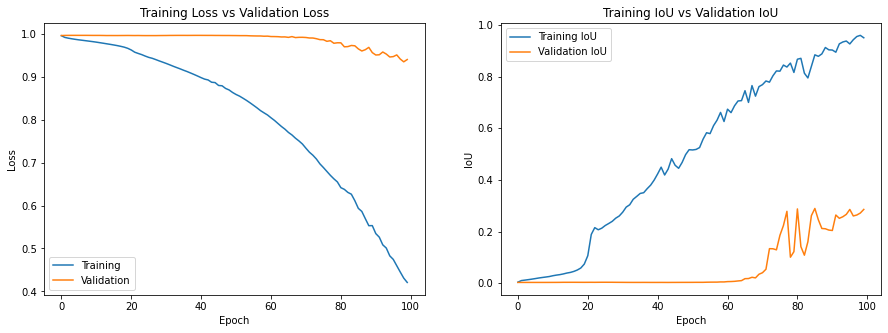

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(model_history.history['loss'])
axs[0].plot(model_history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Training', 'Validation'])

axs[1].plot(model_history.history['iou'])
#axs[1].plot(model_history.history['accuracy'])
axs[1].plot(model_history.history['val_iou'])
#axs[1].plot(model_history.history['val_accuracy'])
axs[1].title.set_text('Training IoU vs Validation IoU')
axs[1].legend(['Training IoU', 'Validation IoU'])

a = plt.setp(axs[0], xlabel='Epoch')
a = plt.setp(axs[0], ylabel='Loss')
a = plt.setp(axs[1], xlabel='Epoch')
a = plt.setp(axs[1], ylabel='IoU')

In [ ]:
score = model.evaluate(np.array(img_test, np.float32), np.array(msk_test, np.float32))
print('Test loss:', score[0])
print('Test IoU:', score[1])

Check predictions

In [198]:
root_path_2 = "/Users/I559573/Documents/D2V2.0_PREP/btp-ai-core-bootcamp/src/ai-models/defect-detection"
from tensorflow.keras import models
trained_model = models.load_model(root_path_2+"/code/train_seg/e79c84506deb1343"
                                  ,custom_objects = {"iou_loss": iou_loss, "IoUCustom": IoUCustom}
                                 )

In [98]:
pred_mask_train = model.predict((np.array(img_train, np.float32)))

In [120]:
pred_mask_val = model.predict((np.array(img_val, np.float32)))

In [213]:
pred_mask_test = model.predict((np.array(img_test, np.float32)))

In [74]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [75]:
def create_mask(pred_mask, a, b):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = (np.array(pred_mask, np.float32)*255).astype(np.uint8)
    blur = cv2.GaussianBlur(pred_mask,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    th3 = th3.reshape(a,b,1)
    #return pred_mask
    return th3

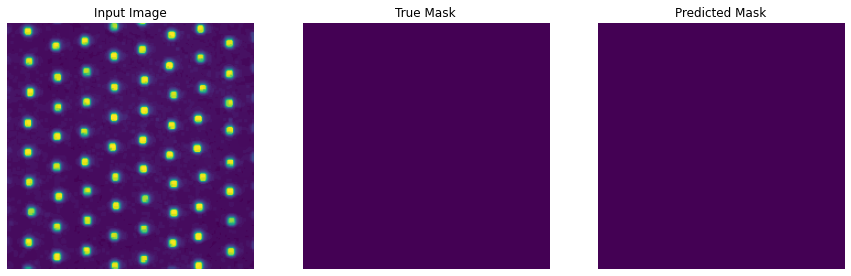

In [76]:
i = 0
pred = create_mask(pred_mask_train[i], 184, 184)
a = (np.array(img_train[i], np.float32))
b = (np.array(msk_train[i], np.float32))
c = (np.array(pred, np.float32))

display([a, b, c])

In [80]:
from base64 import b64encode
import base64
import io
from json import dumps

def encode_image(img):
    ENCODING = 'utf-8'

    # second: base64 encode read data
    # result: bytes (again)
    base64_bytes = b64encode(img)

    # third: decode these bytes to text
    # result: string (in utf-8)
    base64_string = base64_bytes.decode(ENCODING)

    return base64_string

In [101]:
success, encoded_image = cv2.imencode('.bmp', create_mask(pred_mask_train[0], 184, 184))
content2 = encoded_image.tobytes()

In [105]:
a = encode_image(content2)

In [103]:
def load_image(data, IMG_WIDTH, IMG_HEIGHT):
    image = cv2.imdecode(data, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
    image = np.array(image)
    image = image.astype('float32')
    image /= 255
    return image

In [106]:
image_file_as_binary = base64.b64decode(a)
nparr = np.frombuffer(image_file_as_binary, np.uint8)
x_inference = load_image(nparr, 184, 184)
b = np.array([np.array(x_inference)])

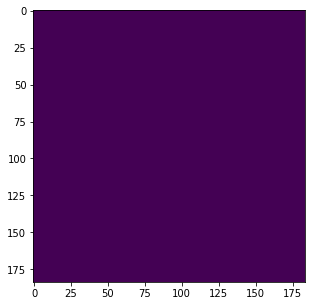

In [113]:
plt.figure(figsize = (5, 5))
plt.imshow(b[0], interpolation='nearest')

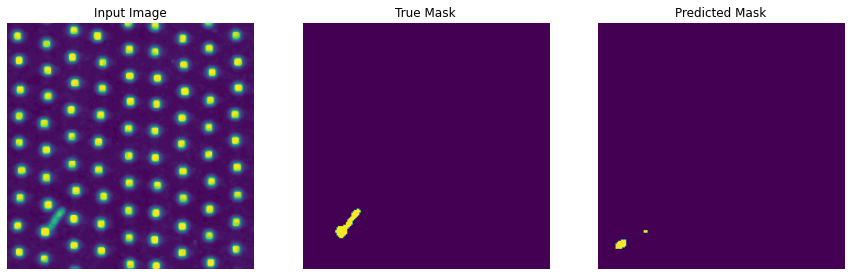

In [121]:
i = 5
pred = create_mask(pred_mask_val[i], 184, 184)
a = (np.array(img_val[i], np.float32))
b = (np.array(msk_val[i], np.float32))
c = (np.array(pred, np.float32))

display([a, b, c])

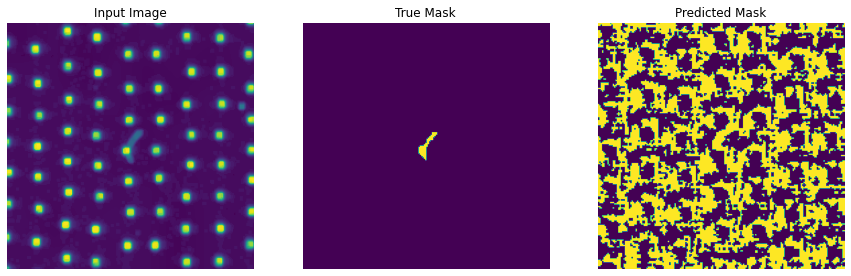

In [233]:
i = 560
pred = create_mask(pred_mask_test[i], 184, 184)
a = (np.array(img_test[i], np.float32))
b = (np.array(msk_test[i], np.float32))
c = (np.array(pred, np.float32))

display([a, b, c])

Calculate percentage of defected area:

In [115]:
def defected_area(img, pred):
    if(pred):
        imgf = tf.argmax(img, axis=-1)
        num = tf.reduce_sum(imgf)
        num = num.numpy()
    else:
        num = np.sum(img)
    #print(num)
    dims = img.shape
    den = dims[0]*dims[1]
    #print(den)
    #print(num/den if den else 0)
    return (num/den if den else 0)

In [117]:
ar = defected_area(create_mask(pred_mask_train[0], 184, 184), True)
print(ar)

0.0


In [528]:
#for i in range(len(pred_mask_train)):
#    print(defected_area(pred_mask_train[i], True))

In [529]:
#for i in range(len(msk_test)):
#    print(defected_area(msk_test[i], False))

In [569]:
a = list(defected_area(np.array(msk_train)[i], False) for i in range(len(msk_train)))
b = list(defected_area(np.array(msk_val)[i], False) for i in range(len(msk_val)))
c = list(defected_area(np.array(msk_test)[i], False) for i in range(len(msk_test)))
print(len(a), len(b), len(c))

493 164 165


In [570]:
tot = a + b + c

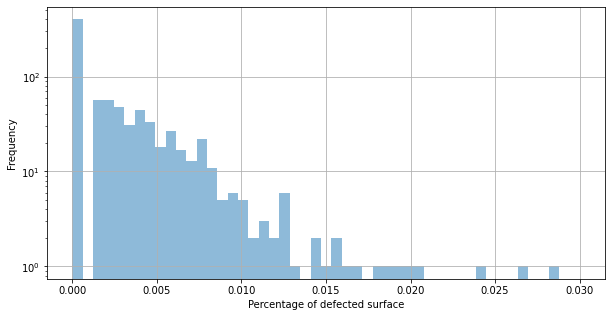

In [578]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 0.03, 50)
plt.hist(tot, bins=bins, alpha=0.5, label="Percentage of defected surface")
#plt.title("Distribution of Percentage of defected surface")
#plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Percentage of defected surface')
plt.show()

In [ ]:
output_path = '/Users/I559573/Downloads'
model_name = 'image_segmentation'
model.save(output_path+'/'+model_name)

In [ ]:
a = models.load_model(output_path+'/'+model_name, custom_objects = {"iou_loss": iou_loss, "IoUCustom": IoUCustom})

Check packages

In [122]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.3
pandas==1.4.2
tensorflow==2.8.0
matplotlib==3.5.1
keras==2.8.0
joblib==1.1.0
cv2==4.5.5
albumentations==1.1.0


In [123]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

scipy==1.8.0
scikit-learn==1.0.2
pandas==1.4.2
numpy==1.22.3
matplotlib==3.5.1
keras==2.8.0
joblib==1.1.0
albumentations==1.1.0
